# Ex🪐plain: Explaining degraded performance in exoplanets atmospheric parameters

## Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)
import pickle
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import os

from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer 
from divexplorer.FP_Divergence import FP_Divergence

from utils_analysis import plotShapleyValue
from ensemble import MC_Convtrainer

import warnings
warnings.filterwarnings("ignore")

In [2]:
if not os.path.exists('plot_results'):
    os.makedirs('plot_results')

## Load posterior scores

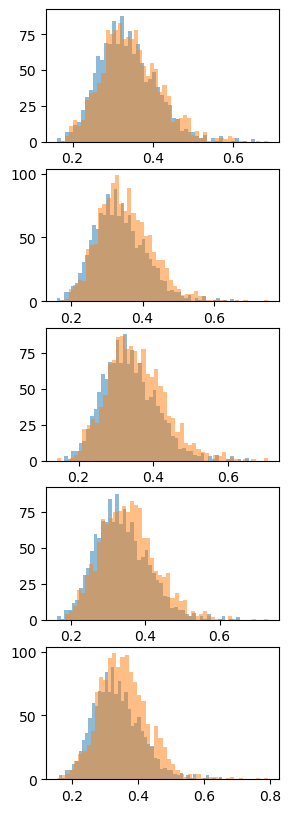

In [3]:
with open("posteriors-5est.pkl", "rb") as f:
    model, posterior_scores, ensemble_scores, valid_aux = pickle.load(f)
    fig, ax = plt.subplots(posterior_scores.shape[0], figsize=(3, 10))
    for i, ps in enumerate(posterior_scores):
        ax[i].hist(ensemble_scores, bins=50, alpha=.5)  # blue => ensemble
        ax[i].hist(ps, bins=50, alpha=.5)               # orange => individual

## BinsDiscretizer and DivExplorer

In [4]:
col_names = [
    "star_distance",
    "star_mass",
    "star_radius",
    "star_temperature",
    "planet_mass",
    "planet_orbital_period",
    "planet_semi_major_axis",
    "planet_surface_gravity",
]
uom = [r"pc", r"M_\odot", r"R_\odot", r"K", r"M_J", r"days", r"AU", r"ms^{-2}"] 

In [5]:
""" 
    Function to get the divergence from the predictions using DivExplorer:
    - posterior_scores: posterior scores of the model (ensemble in our case)
    - valid_aux: auxiliary data of the validation set
    - col_names: names of the columns of the auxiliary data
    - uom: units of measure of the auxiliary data
    - minsup: minimum support for the frequent pattern mining
"""
def get_div_from_predictions(posterior_scores, valid_aux, col_names, uom, minsup=0.01):

    scaling = np.array([
        1, 2e30, 6.95700e8, 1, 1.898e27, 1, 1, 1
    ])

    kbins = KBinsDiscretizer(n_bins=10, encode="onehot-dense", strategy="quantile")
    
    parser = name_parser(kbins, col_names, uom)
    data = kbins.fit_transform(pd.DataFrame(data=valid_aux / scaling, columns=col_names))
    onehot_col_names = [ parser(f'{"_".join(s.split("_")[:-1])}={s.split("_")[-1]}') for s in kbins.get_feature_names_out() ]

    df = pd.DataFrame(data=data , columns=onehot_col_names, dtype=bool)
    df["posterior_score"] = posterior_scores

    fp_diver = FP_DivergenceExplorer(df, is_one_hot_encoding=True, target_name="posterior_score")

    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=minsup, metrics=["d_outcome"])

    fp_divergence = FP_Divergence(FP_fm,'d_outcome')
    FPdiv = fp_divergence.getDivergence(th_redundancy=None)[::-1] 
    return fp_divergence, FPdiv

In [6]:
"""
    Function for associating names and uoms to the discretized bins:
    - kins: discretized bins
    - col_names: names of the columns of the auxiliary data
    - uom: units of measure of the auxiliary data
"""
def name_parser(kbins, col_names, uom):
    def parse(names):
        parsed = []
        is_str = False
        if isinstance(names, str):
            is_str = True
            names = names.split(",")
        for name in names:
            name = name.strip()
            variable, bin = name.split("=")
            bin = int(float(bin))
            pos = col_names.index(variable)

            start_bin = kbins.bin_edges_[pos][bin]
            end_bin = kbins.bin_edges_[pos][bin+1]

            if start_bin > 1e4 and end_bin > 1e4:
                exp = np.floor(np.log10(start_bin))
                start_bin = start_bin / 10**exp
                end_bin = end_bin / 10**exp
                fstr = rf"{variable} $\in$ [{start_bin:.2f}, {end_bin:.2f}) x $10^{int(exp)}$ ${uom[pos]}$"
            else:
                fstr = rf"{variable} $\in$ [{kbins.bin_edges_[pos][bin]:.2f}, {kbins.bin_edges_[pos][bin+1]:.2f}) ${uom[pos]}$"
            parsed.append(fstr)
        
        if is_str:
            return ", ".join(parsed)
        else: 
            assert isinstance(names, list) or isinstance(names, frozenset)
            return frozenset(parsed)

    return parse

In [7]:
## Getting divergences of ensemble and weak learner
fp_ensemble, div_ensemble = get_div_from_predictions(ensemble_scores, valid_aux, col_names, uom)
c = [ get_div_from_predictions(ps, valid_aux, col_names, uom) for ps in posterior_scores ]
fp_individual, div_individual = [x[0] for x in c],  [x[1] for x in c ]

In [8]:
FPdiv_ensemble = fp_ensemble.getDivergence(th_redundancy=0.03).copy()
de = FPdiv_ensemble.set_index("itemsets")

In [9]:
FPdiv_individual = fp_individual[0].getDivergence(th_redundancy=0.03).copy()
di = FPdiv_individual.set_index("itemsets")

## Ensemble Divergence

In [10]:
## Most negatively divergent subgroups
de.head(3)

,support,length,support_count,outcome,d_outcome,t_value_outcome
itemsets,,,,,,
"(planet_orbital_period $\in$ [34.76, 731.94) $days$, planet_surface_gravity $\in$ [13.10, 18.38) $ms^{-2}$)",0.011817,2,16.0,0.412931,0.076037,3.275614
"(planet_semi_major_axis $\in$ [0.01, 0.04) $AU$, planet_surface_gravity $\in$ [4.36, 5.58) $ms^{-2}$)",0.011078,2,15.0,0.411669,0.074775,2.808425
"(planet_semi_major_axis $\in$ [0.21, 1.50) $AU$, planet_surface_gravity $\in$ [13.10, 18.38) $ms^{-2}$)",0.012555,2,17.0,0.409086,0.072192,3.255728


In [11]:
## Most positively divergent subgroups
de[::-1].head(3)

,support,length,support_count,outcome,d_outcome,t_value_outcome
itemsets,,,,,,
"(star_radius $\in$ [1.21, 1.35) $R_\odot$, planet_semi_major_axis $\in$ [0.04, 0.05) $AU$)",0.010340,2,14.0,0.281855,-0.055039,3.769326
"(star_distance $\in$ [244.97, 348.43) $pc$, planet_orbital_period $\in$ [2.78, 3.66) $days$)",0.010340,2,14.0,0.283926,-0.052968,2.650584
"(star_mass $\in$ [1.01, 1.07) $M_\odot$, planet_orbital_period $\in$ [4.64, 6.37) $days$)",0.011078,2,15.0,0.286371,-0.050523,2.447390


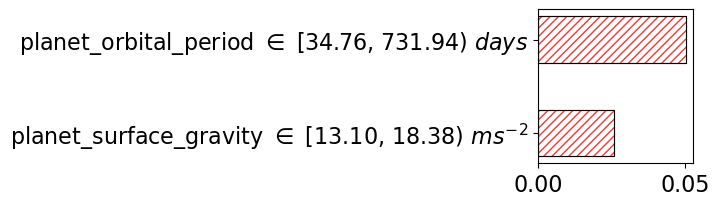

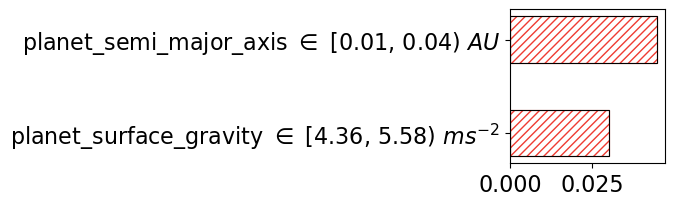

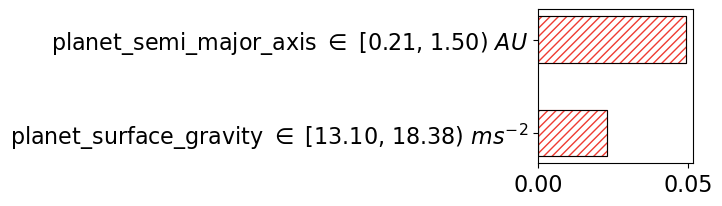

In [12]:
for i in range(3):
    itemset_shap = fp_ensemble.computeShapleyValue(de.iloc[i].name)
    plotShapleyValue(shapley_values=itemset_shap, \
                    sizeFig=(2,2), labelsize=16, titlesize=16, 
                    nameFig=f'plot_results/shapley_value_ensemble_negative_{i}.pdf', saveFig=True)

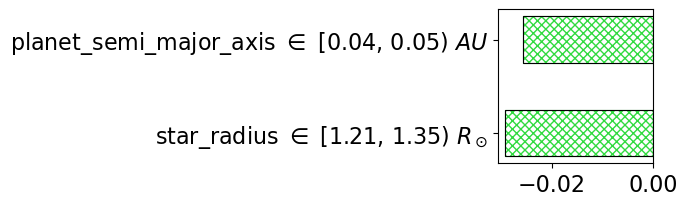

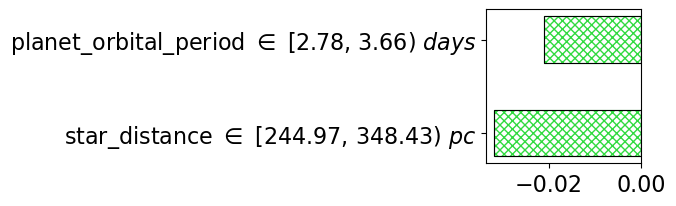

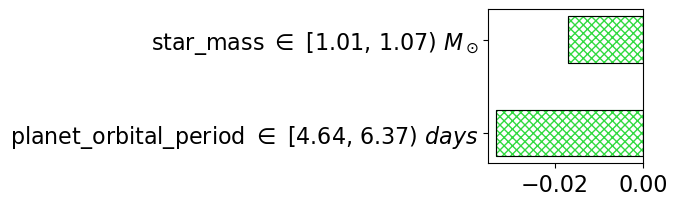

In [13]:
for i in range(3):
    itemset_shap = fp_ensemble.computeShapleyValue(de[::-1].iloc[i].name)
    plotShapleyValue(shapley_values=itemset_shap, \
                    sizeFig=(2,2), labelsize=16, titlesize=16,
                    nameFig=f'plot_results/shapley_value_ensemble_positive_{i}.pdf', saveFig=True)

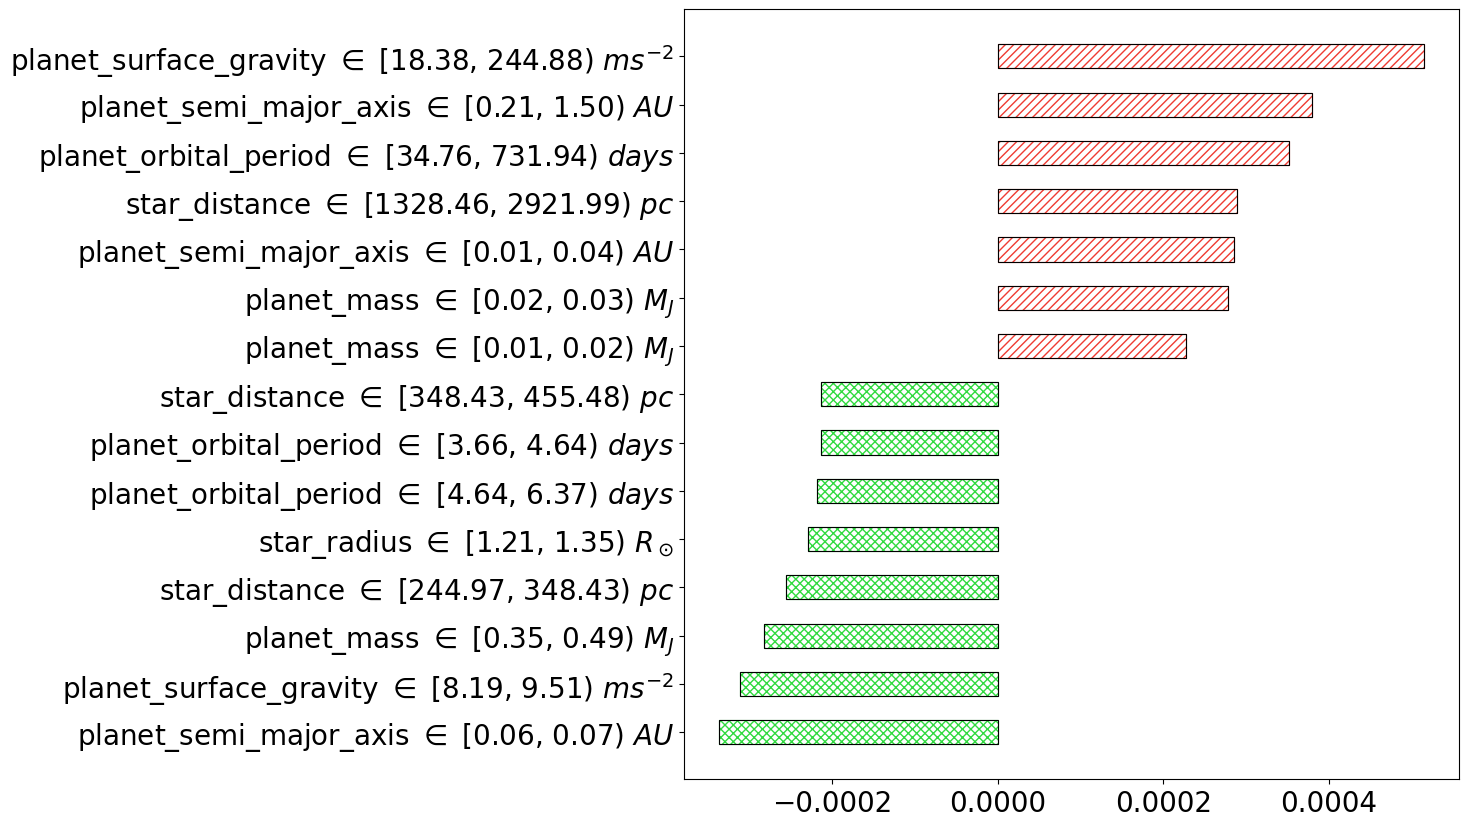

In [14]:
## Global Shapley values
global_item_divergence = fp_ensemble.computeGlobalShapleyValue()

K= 15
topK_global = {k:v for k,v in global_item_divergence.items() 
                if k in sorted(global_item_divergence, 
                key=lambda x: abs(global_item_divergence[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global, 
                sizeFig=(10,10), labelsize=20, titlesize=20,
                saveFig=True, nameFig="plot_results/global_divergence_ensemble.pdf")

## Weak Learner Divergence

In [15]:
## Most negatively divergent subgroups
di.head(3)

,support,length,support_count,outcome,d_outcome,t_value_outcome
itemsets,,,,,,
"(planet_orbital_period $\in$ [34.76, 731.94) $days$, planet_surface_gravity $\in$ [13.10, 18.38) $ms^{-2}$)",0.011817,2,16.0,0.424590,0.077430,2.929255
"(planet_semi_major_axis $\in$ [0.01, 0.04) $AU$, planet_surface_gravity $\in$ [4.36, 5.58) $ms^{-2}$)",0.011078,2,15.0,0.424058,0.076898,2.769639
"(planet_semi_major_axis $\in$ [0.21, 1.50) $AU$, planet_mass $\in$ [0.01, 0.02) $M_J$)",0.014032,2,19.0,0.420496,0.073337,2.990196


In [16]:
## Most positively divergent subgroups
di[::-1].head(3)

,support,length,support_count,outcome,d_outcome,t_value_outcome
itemsets,,,,,,
"(star_distance $\in$ [244.97, 348.43) $pc$, planet_orbital_period $\in$ [2.78, 3.66) $days$)",0.010340,2,14.0,0.290160,-0.057000,3.105308
"(planet_semi_major_axis $\in$ [0.04, 0.05) $AU$, star_distance $\in$ [244.97, 348.43) $pc$)",0.012555,2,17.0,0.293518,-0.053642,3.262563
"(planet_mass $\in$ [0.29, 0.35) $M_J$, planet_orbital_period $\in$ [4.64, 6.37) $days$)",0.012555,2,17.0,0.294622,-0.052538,3.001432


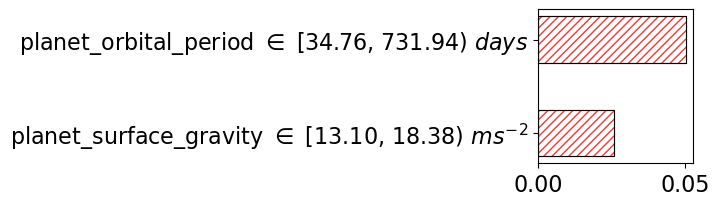

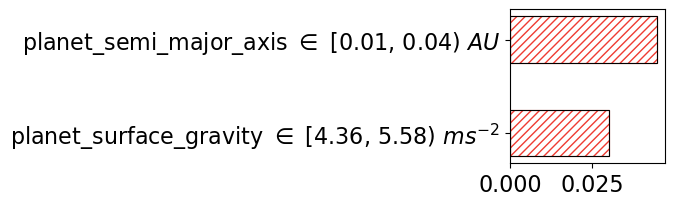

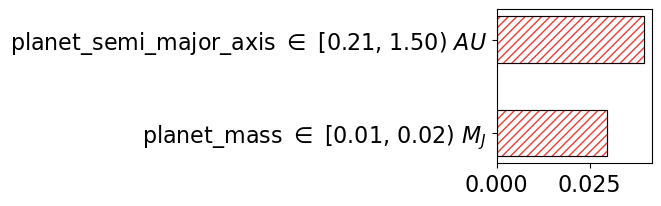

In [17]:
for i in range(3):
    itemset_shap = fp_ensemble.computeShapleyValue(di.iloc[i].name)
    plotShapleyValue(shapley_values=itemset_shap, \
                    sizeFig=(2,2), labelsize=16, titlesize=16, 
                    nameFig=f'plot_results/shapley_value_individual_negative_{i}.pdf', saveFig=True)

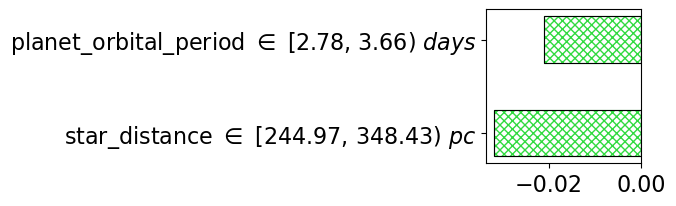

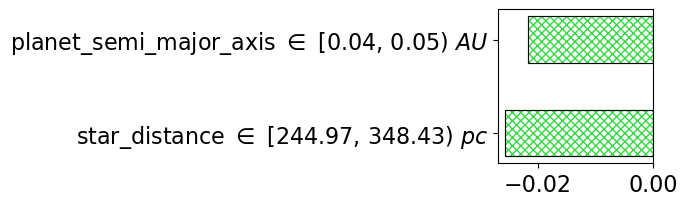

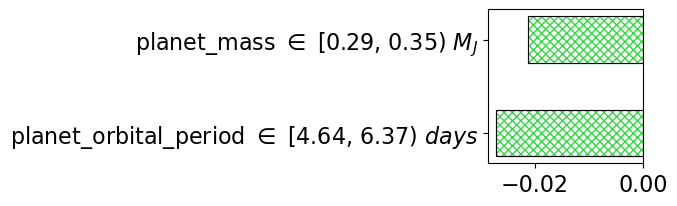

In [18]:
for i in range(3):
    itemset_shap = fp_ensemble.computeShapleyValue(di[::-1].iloc[i].name)
    plotShapleyValue(shapley_values=itemset_shap, \
                    sizeFig=(2,2), labelsize=16, titlesize=16,
                    nameFig=f'plot_results/shapley_value_individual_positive_{i}.pdf', saveFig=True)

## Gain Ensemble vs. Individual

In [19]:
FPdiv_ensemble = fp_ensemble.getDivergence(th_redundancy=None).copy()
de = FPdiv_ensemble.set_index("itemsets")

FPdiv_individual = fp_individual[0].getDivergence(th_redundancy=None).copy()
di = FPdiv_individual.set_index("itemsets")

In [20]:
## Merge the dataframes
merged = di.join(de, lsuffix='_individual', rsuffix='_ensemble')
merged = merged.rename(columns={'support_ensemble': 'support'})

In [21]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["outcome_ensemble"] - merged["outcome_individual"]
merged["difference"] = merged["outcome_ensemble"] - merged["outcome_individual"]

In [22]:
## Create "Gain Individual-Ensemble " df and compute divergence
individual_ensemble_gain_df = merged[[
       'support',
       'outcome_ensemble',
       'd_outcome_ensemble', 
       'support_count_ensemble', 
       'length_ensemble'] \
       + [diff, "difference", "outcome_individual"]]
individual_ensemble_gain_df = individual_ensemble_gain_df.rename(columns={'length_ensemble':'length'})
individual_ensemble_gain_df = individual_ensemble_gain_df.reset_index()

In [23]:
fp_divergence_difference = FP_Divergence(individual_ensemble_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [24]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'outcome_individual', 'outcome_ensemble', 'support']

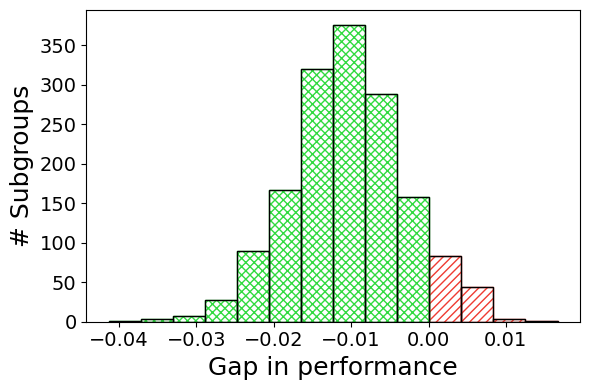

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(list_diff_neg, bins=4, kde=False, ax=ax, hatch="////", color="none", edgecolor='#EF3B32')
sns.histplot(list_diff_neg, bins=4, kde=False, ax=ax, color="none", edgecolor='k')
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, hatch="xxxx", color="none", edgecolor='#31DA40')
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color="none", edgecolor='k')

ax.set_xlabel("Gap in performance", fontsize=18)
ax.set_ylabel(r"# Subgroups", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("plot_results/distribution_gain_ensemble_individual.pdf")

In [26]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are greater for the ensemble
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for the ensemble
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

Greater
91.8318
Lower
8.1682


In [27]:
## Retrieve the data cohorts for which the ensemble performs better than the individual model
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["outcome_ensemble"] = (pr["outcome_ensemble"]).round(4)
pr["outcome_individual"] = (pr["outcome_individual"]).round(4)
pr["d_difference"] = (pr["d_difference"]).round(4)

pr.head(2)

,itemsets,d_difference,outcome_individual,outcome_ensemble,support
0,"(star_radius $\in$ [1.62, 6.30) $R_\odot$, planet_surface_gravity $\in$ [18.38, 244.88) $ms^{-2}$)",-0.0413,0.3813,0.3400,0.01
1,"(planet_mass $\in$ [0.49, 9.48) $M_J$, star_radius $\in$ [1.62, 6.30) $R_\odot$, planet_surface_gravity $\in$ [18.38, 244.88) $ms^{-2}$)",-0.0365,0.3620,0.3255,0.01


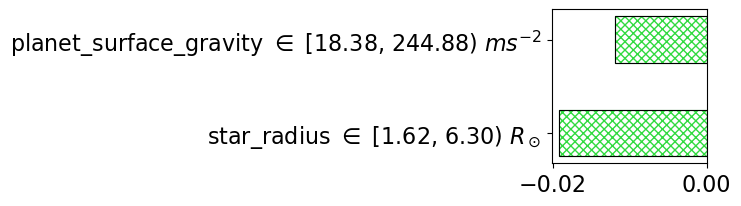

In [28]:
## Compute Shapley Values for a given itemset
itemset_shap = fp_divergence_difference.computeShapleyValue(pr.iloc[0].itemsets)
itemset_shap = {k:v for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=itemset_shap, \
                sizeFig=(2,2), labelsize=16, titlesize=16, \
                saveFig=True, nameFig="plot_results/shapley_value_gain_positive.pdf")

In [29]:
## Retrieve the data cohorts for which the ensemble performs worse than the individual model
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["outcome_ensemble"] = (pr["outcome_ensemble"]).round(4)
pr["outcome_individual"] = (pr["outcome_individual"]).round(4)
pr["d_difference"] = (pr["d_difference"]).round(4)

pr.head(2)

,itemsets,d_difference,outcome_individual,outcome_ensemble,support
0,"(star_radius $\in$ [0.72, 0.81) $R_\odot$, planet_semi_major_axis $\in$ [0.04, 0.05) $AU$)",0.0167,0.3274,0.3441,0.01
1,"(star_temperature $\in$ [4830.40, 5187.00) $K$, planet_mass $\in$ [0.03, 0.04) $M_J$)",0.0125,0.3420,0.3545,0.01


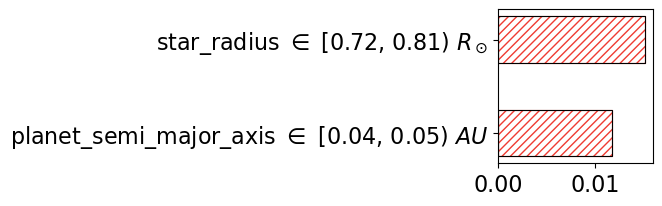

In [30]:
## Compute Shapley Values for a given itemset
itemset_shap = fp_divergence_difference.computeShapleyValue(pr.iloc[0].itemsets)
itemset_shap = {k:v for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=itemset_shap, 
                sizeFig=(2,2), labelsize=16, titlesize=16,
                saveFig=True, nameFig="plot_results/shapley_value_gain_negative.pdf")       

In [31]:
## Retrieve the data cohorts for which the ensemble performs equal to the individual model
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["outcome_ensemble"] = (pr["outcome_ensemble"]).round(4)
pr["outcome_individual"] = (pr["outcome_individual"]).round(4)
pr["d_difference"] = (pr["d_difference"]).round(4)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("outcome_ensemble")

pr.head(2)

,itemsets,d_difference,outcome_individual,outcome_ensemble,support
129,"(planet_mass $\in$ [0.01, 0.02) $M_J$, star_radius $\in$ [0.30, 0.72) $R_\odot$)",0.0,0.3234,0.3234,0.01
131,"(planet_semi_major_axis $\in$ [0.08, 0.10) $AU$, planet_mass $\in$ [0.02, 0.03) $M_J$)",-0.0,0.3425,0.3425,0.01


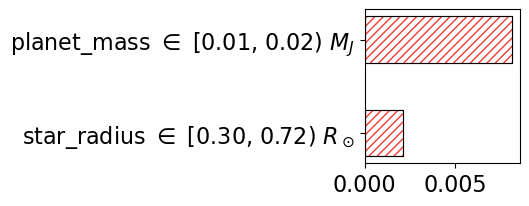

In [32]:
## Compute Shapley Values for a given itemset
itemset_shap = fp_divergence_difference.computeShapleyValue(pr.iloc[0].itemsets)
itemset_shap = {k:v for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=itemset_shap, 
                sizeFig=(2,2), labelsize=16, titlesize=16,
                saveFig=True, nameFig="plot_results/shapley_value_gain_equal.pdf")   

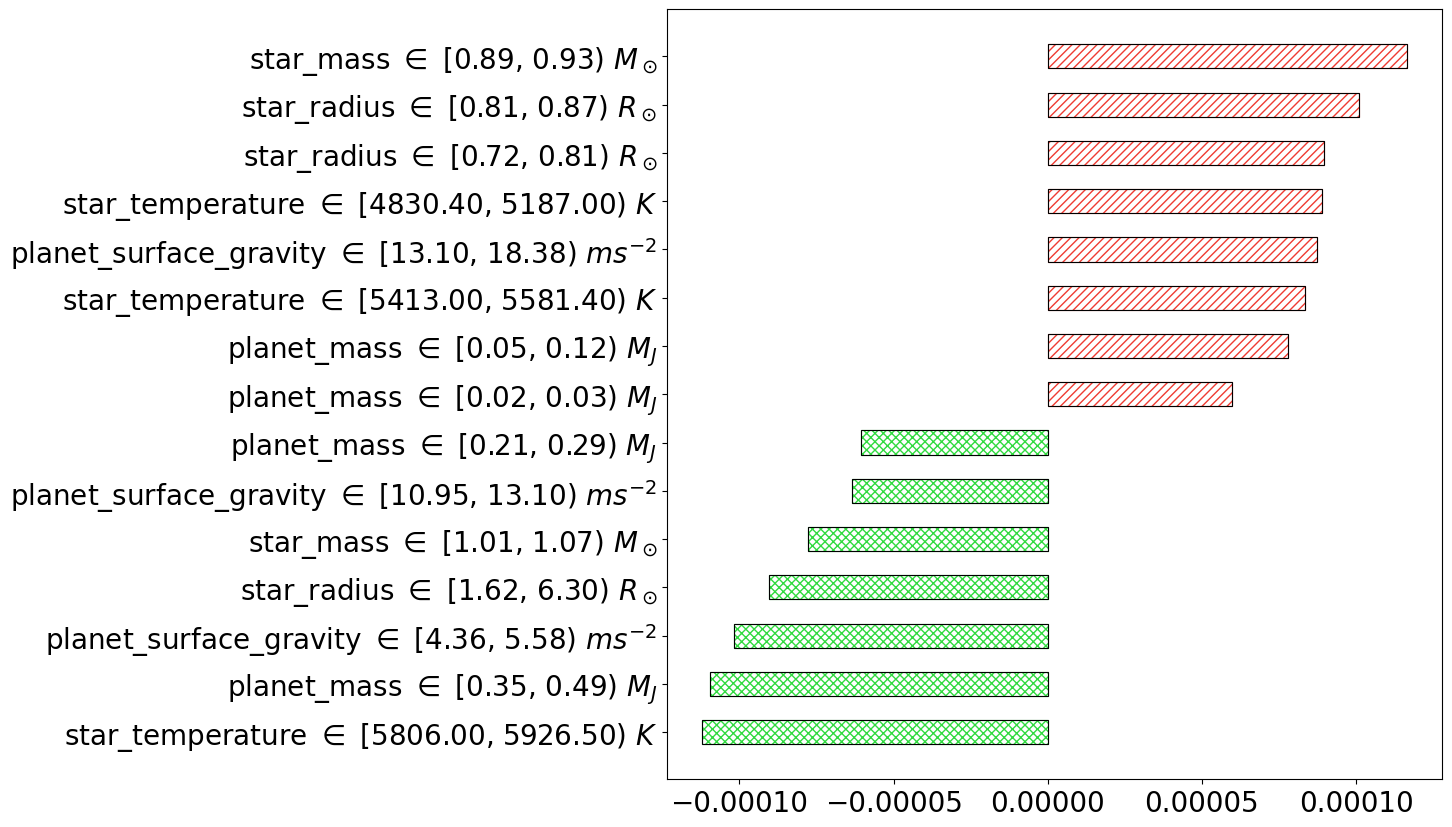

In [33]:
## Global Shapley values
global_item_divergence = fp_divergence_difference.computeGlobalShapleyValue()

K= 15
topK_global = {k:v for k,v in global_item_divergence.items() 
                if k in sorted(global_item_divergence, 
                key=lambda x: abs(global_item_divergence[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global, 
                sizeFig=(10,10), labelsize=20, titlesize=20,
                saveFig=True, nameFig="plot_results/global_divergence_gain.pdf")

## Gain Weak Learners vs. Weak Learner

In [34]:
FPdiv_individual_1 = fp_individual[0].getDivergence(th_redundancy=None).copy()
di_1 = FPdiv_individual_1.set_index("itemsets")

FPdiv_individual_2 = fp_individual[1].getDivergence(th_redundancy=None).copy()
di_2 = FPdiv_individual_2.set_index("itemsets")

In [35]:
## Merge the dataframes
merged = di_1.join(di_2, lsuffix='_individual_1', rsuffix='_individual_2')
merged = merged.rename(columns={'support_individual_2': 'support'})

In [36]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["outcome_individual_2"] - merged["outcome_individual_1"]
merged["difference"] = merged["outcome_individual_2"] - merged["outcome_individual_1"]

In [37]:
## Create "Gain Individual-Individual " df and compute divergence
individual_individual_gain_df = merged[[
       'support',
       'outcome_individual_2',
       'd_outcome_individual_2', 
       'support_count_individual_2', 
       'length_individual_2'] \
       + [diff, "difference", "outcome_individual_1"]]
individual_individual_gain_df = individual_individual_gain_df.rename(columns={'length_individual_2':'length'})
individual_individual_gain_df = individual_individual_gain_df.reset_index()

In [38]:
fp_divergence_difference = FP_Divergence(individual_individual_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [39]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'outcome_individual_1', 'outcome_individual_2', 'support']

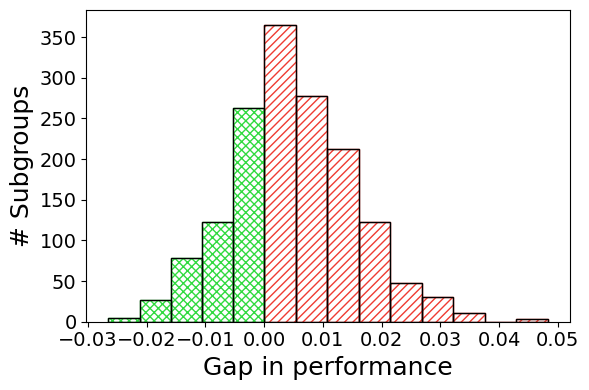

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(list_diff_neg, bins=9, kde=False, ax=ax, hatch="////", color="none", edgecolor='#EF3B32')
sns.histplot(list_diff_neg, bins=9, kde=False, ax=ax, color="none", edgecolor='k')
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=5, kde=False, ax=ax, hatch="xxxx", color="none", edgecolor='#31DA40')
sns.histplot(list_diff_pos, bins=5, kde=False, ax=ax, color="none", edgecolor='k')

ax.set_xlabel("Gap in performance", fontsize=18)
ax.set_ylabel(r"# Subgroups", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("plot_results/distribution_gain_individual_individual.pdf")

In [41]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are greater for the second individual weak learner
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for the second individual weak learner
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

Greater
32.012
Lower
67.988


In [42]:
## Retrieve the data cohorts for which the second weak learner performs better than the first
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["outcome_individual_2"] = (pr["outcome_individual_2"]).round(4)
pr["outcome_individual_1"] = (pr["outcome_individual_1"]).round(4)
pr["d_difference"] = (pr["d_difference"]).round(4)

pr.head(2)

,itemsets,d_difference,outcome_individual_1,outcome_individual_2,support
0,"(star_radius $\in$ [1.21, 1.35) $R_\odot$, star_temperature $\in$ [6234.80, 10170.00) $K$)",-0.0265,0.3579,0.3314,0.01
1,"(star_radius $\in$ [1.62, 6.30) $R_\odot$, planet_surface_gravity $\in$ [18.38, 244.88) $ms^{-2}$)",-0.0260,0.3813,0.3553,0.01


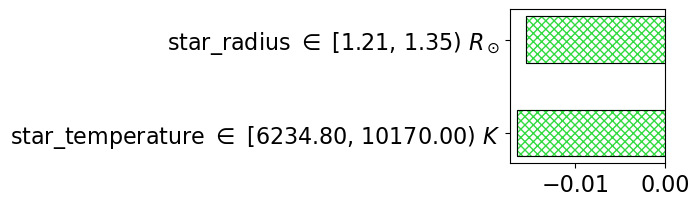

In [43]:
## Compute Shapley Values for a given itemset
itemset_shap = fp_divergence_difference.computeShapleyValue(pr.iloc[0].itemsets)
itemset_shap = {k:v for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=itemset_shap, \
                sizeFig=(2,2), labelsize=16, titlesize=16, \
                saveFig=True, nameFig="plot_results/shapley_value_gain_i_i_positive.pdf")

In [44]:
## Retrieve the data cohorts for which the second weak learner performs worse than the first
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["outcome_individual_2"] = (pr["outcome_individual_2"]).round(4)
pr["outcome_individual_1"] = (pr["outcome_individual_1"]).round(4)
pr["d_difference"] = (pr["d_difference"]).round(4)

pr.head(2)

,itemsets,d_difference,outcome_individual_1,outcome_individual_2,support
0,"(star_temperature $\in$ [4830.40, 5187.00) $K$, star_radius $\in$ [1.62, 6.30) $R_\odot$)",0.0483,0.3703,0.4186,0.01
1,"(star_distance $\in$ [1056.41, 1328.46) $pc$, planet_mass $\in$ [0.01, 0.02) $M_J$)",0.0457,0.4005,0.4463,0.01


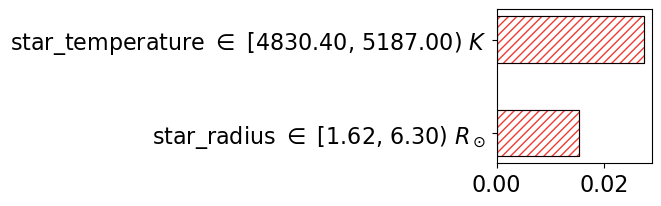

In [45]:
## Compute Shapley Values for a given itemset
itemset_shap = fp_divergence_difference.computeShapleyValue(pr.iloc[0].itemsets)
itemset_shap = {k:v for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=itemset_shap, 
                sizeFig=(2,2), labelsize=16, titlesize=16,
                saveFig=True, nameFig="plot_results/shapley_value_gain_i_i_negative.pdf")       

In [46]:
## Retrieve the data cohorts for which the second weak learner performs equal to the first
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["outcome_individual_2"] = (pr["outcome_individual_2"]).round(4)
pr["outcome_individual_1"] = (pr["outcome_individual_1"]).round(4)
pr["d_difference"] = (pr["d_difference"]).round(4)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("outcome_individual_2")

pr.head(2)

,itemsets,d_difference,outcome_individual_1,outcome_individual_2,support
1070,"(planet_surface_gravity $\in$ [5.58, 6.48) $ms^{-2}$, star_radius $\in$ [0.93, 1.00) $R_\odot$)",-0.0,0.3339,0.3339,0.01
1069,"(star_temperature $\in$ [5581.40, 5699.00) $K$, star_mass $\in$ [0.97, 1.01) $M_\odot$)",0.0,0.3384,0.3385,0.01


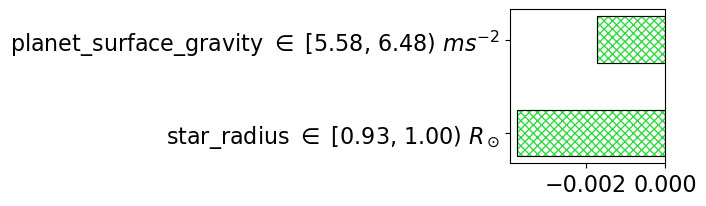

In [47]:
## Compute Shapley Values for a given itemset
itemset_shap = fp_divergence_difference.computeShapleyValue(pr.iloc[0].itemsets)
itemset_shap = {k:v for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=itemset_shap, 
                sizeFig=(2,2), labelsize=16, titlesize=16,
                saveFig=True, nameFig="plot_results/shapley_value_gain_i_i_equal.pdf")   

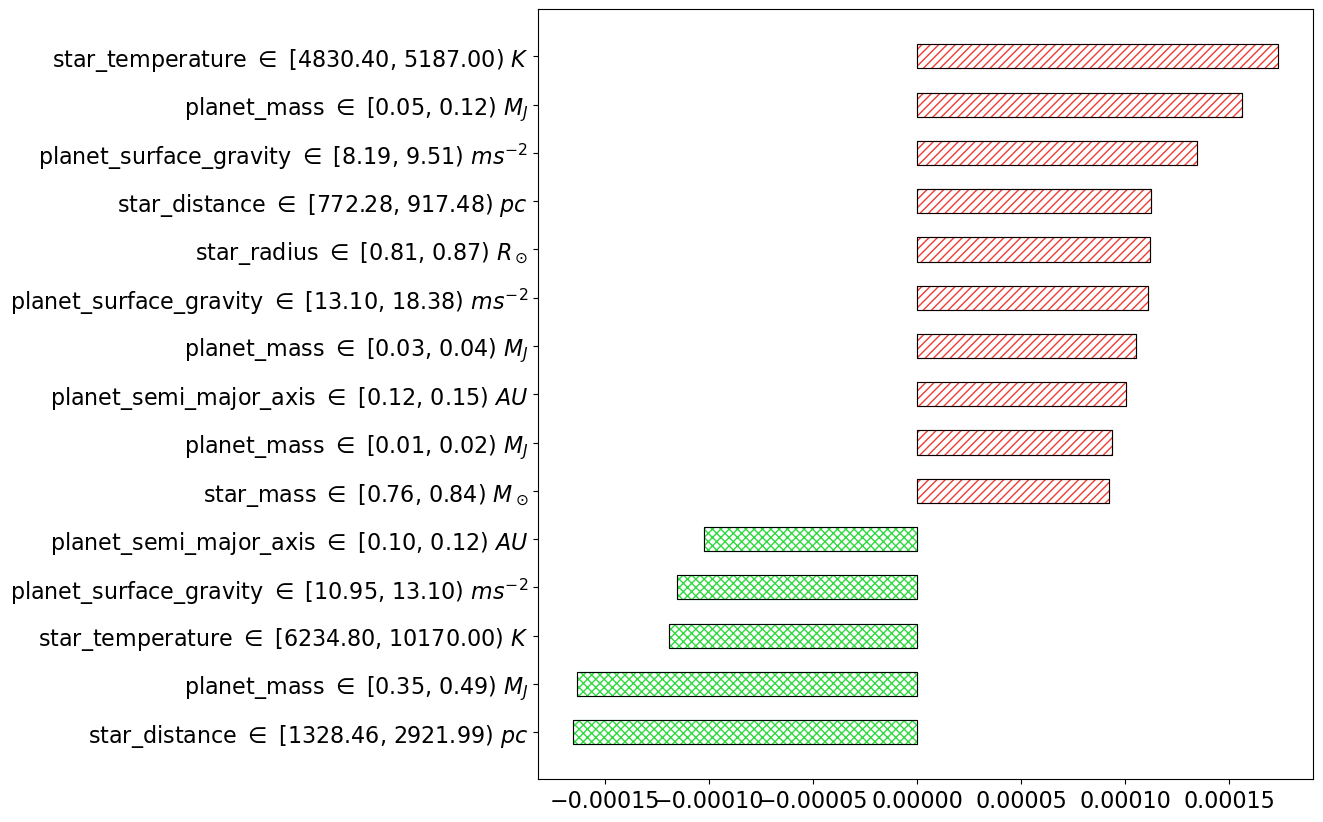

In [48]:
## Global Shapley values
global_item_divergence = fp_divergence_difference.computeGlobalShapleyValue()

K= 15
topK_global = {k:v for k,v in global_item_divergence.items() 
                if k in sorted(global_item_divergence, 
                key=lambda x: abs(global_item_divergence[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global, 
                sizeFig=(10,10), labelsize=16, titlesize=16,
                saveFig=True, nameFig="plot_results/global_divergence_gain_i_i.pdf")